In [9]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from ultralytics import YOLO

In [10]:
class ModelAnalyzer():
    """Класс для количественного сравнения метрик моделей"""
    def __init__(self, dataset_path):
        self.dataset_path = Path(dataset_path)
        self.test_images = list((self.dataset_path / "test" / "images").glob("*.jpg")) # Загружаем тестовые изображения для анализа
        self.results = {} # Словарь для хранения результатов

    def test_model(self, model_name, model_path):
        """Тестирование одной модели на всех изображениях"""
        if not Path(model_path).exists():
            return None

        model = YOLO(model_path)
        detections = []
        confidences = []
        correct_predictions = 0  # Счетчик правильных предсказаний

        for img_path in self.test_images:
            results = model(img_path, conf=0.15, verbose=False)
            
            if results[0].boxes:
                num_detections = len(results[0].boxes)
                detections.append(num_detections)
                
                # Правильно, если найден РОВНО ОДИН кубсат
                if num_detections == 1:
                    correct_predictions += 1
                    for box in results[0].boxes:
                        confidences.append(box.conf[0].item())
            else:
                # Ноль детекций - тоже ошибка (пропуск объекта)
                detections.append(0)
                
    
        # Точность = правильно определенные / всего изображений
        accuracy = (correct_predictions / len(self.test_images)) * 100

        return {
            'detections': np.mean(detections),
            'accuracy': accuracy,
            'confidence': np.mean(confidences) if confidences else 0
        }

    def run_comparison(self):
        """Запуск сравнения двух моделей"""
        models = [
            ('YOLOv8n', 'yolov8n.pt'),
            ('Наша модель', 'best.pt')
        ]

        for name, path in models:
            result = self.test_model(name, path)
            if result:
                self.results[name] = result

    def plot_results(self):
        """Создание сравнительных диаграмм с тремя метриками"""
        if not self.results:
            print("Нет результатов")
            return

        names = list(self.results.keys())
        detections = [self.results[n]['detections'] for n in names]
        accuracy_values = [self.results[n]['accuracy'] for n in names]
        confidence = [self.results[n]['confidence'] for n in names]

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

        colors = ['#3498db', '#2ecc71'] # Синий для YOLOv8n, зеленый для нашей модели

        # 1. Детекции
        bars1 = ax1.bar(names, detections, color=colors, edgecolor='black')
        ax1.set_title('Среднее количество детекций', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Количество')

        # Процент улучшения для детекций
        if len(detections) == 2:
            det_imp = ((detections[1] / detections[0]) - 1) * 100
            ax1.text(0.5, -0.15, f"+{det_imp:.1f}%", transform=ax1.transAxes,
                     ha='center', fontsize=12, fontweight='bold', color='green')

        for bar in bars1:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width() / 2, height * 1.02,
                     f'{height:.2f}', ha='center', fontweight='bold')

        # 2. Точность определения кубсатов
        bars2 = ax2.bar(names, accuracy_values, color=colors, edgecolor='black')
        ax2.set_title('Точность определения кубсатов', fontsize=14, fontweight='bold')
        ax2.set_ylabel('Точность, %')
        ax2.set_ylim(0, 100)  # Ограничение для процентов
        
        # Процент улучшения для точности
        if len(accuracy_values) == 2:
            accuracy_imp = ((accuracy_values[1] / accuracy_values[0]) - 1) * 100
            color = 'green' if accuracy_imp > 0 else 'red' # Зеленый, если лучше
            sign = "+" if accuracy_imp > 0 else ""
            ax2.text(0.5, -0.15, f"{sign}{accuracy_imp:.1f}%", transform=ax2.transAxes,
                     ha='center', fontsize=12, fontweight='bold', color=color)
        
        for bar in bars2:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width() / 2, height * 1.02,
                     f'{height:.1f}%', ha='center', fontweight='bold')
        
        # 3. Уверенность
        bars3 = ax3.bar(names, confidence, color=colors, edgecolor='black')
        ax3.set_title('Средняя уверенность', fontsize=14, fontweight='bold')
        ax3.set_ylabel('Уверенность')
        ax3.set_ylim(0, 1) # Ограничение от 0 до 1

        # Процент улучшения для уверенности
        if len(confidence) == 2:
            conf_imp = ((confidence[1] / confidence[0]) - 1) * 100
            color = 'green' if conf_imp > 0 else 'red' # Зеленый, если лучше
            sign = "+" if conf_imp > 0 else ""
            ax3.text(0.5, -0.15, f"{sign}{conf_imp:.1f}%", transform=ax3.transAxes,
                     ha='center', fontsize=12, fontweight='bold', color=color)

        for bar in bars3:
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width() / 2, height * 1.02,
                     f'{height:.3f}', ha='center', fontweight='bold')

        plt.tight_layout()
        plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
        plt.show()
        print("Диаграмма сохранена: model_comparison.png")

In [11]:
def main():
    dataset_path = r"C:\\Users\\ASUS\\.cache\\kagglehub\\datasets\\eberhardtkorf\\synthetic-cubesat\\versions\\1\\synthetic_cubesat\\dataset"

    analyzer = ModelAnalyzer(dataset_path)
    analyzer.run_comparison()
    analyzer.plot_results()

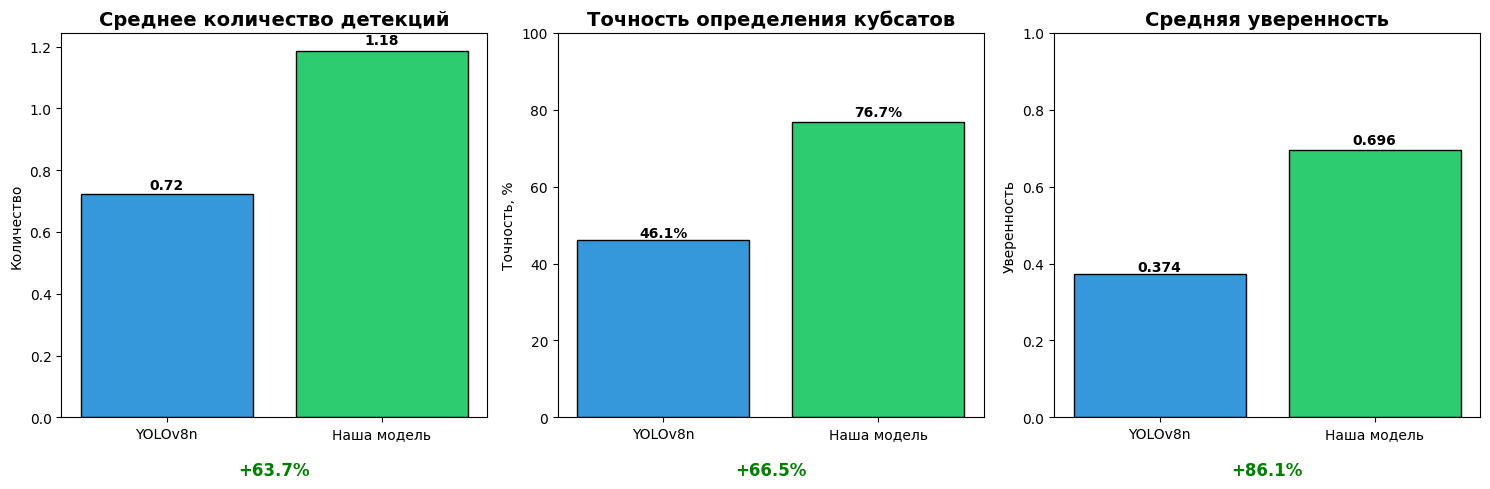

Диаграмма сохранена: model_comparison.png


In [12]:
if __name__ == "__main__":
    main()